In [1]:
from IPython.core.interactiveshell import InteractiveShell
# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"

In [661]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

matplotlib.rcParams.update({'font.size': 11})

%matplotlib notebook

import pandas as pd
import numpy as np

## Get Data

from sqlalchemy import create_engine
import os

In [795]:
attune_dw_host = os.getenv("ATTUNE_DW_HOST")
attune_dw_user = os.getenv("ATTUNE_DW_USER")
attune_dw_db = os.getenv("ATTUNE_DW_DB", "attune_dw")
port = "5432"


class Connection:
    def __init__(self):
        pass

    def dw_engine(self):
        connection_string = (
            f"postgresql://{attune_dw_user}@{attune_dw_host}:{port}/{attune_dw_db}"
        )
        return create_engine(connection_string)

conn = Connection().dw_engine()

### Load Data

In [221]:
query="""
WITH crm_domains AS (
    SELECT
        domain,
        mode() WITHIN GROUP (ORDER BY agency_producer_code) domain_producer_code
    FROM (
             SELECT
                 trim(lower(split_part(email, '@', 2))) AS domain,
                 agency_producer_code
             FROM crm_agents
         ) AS domains
    WHERE
        domain IS NOT NULL
    AND domain NOT IN ('', 'gmail.com', 'yahoo.com',
                         'aol.com', 'msn.com', 'att.net', 'verizon.net', 'hotmail.com',
                         'comcast.net', 'outlook.com', 'bellsouth.net', 'sbcglobal.net',
                         'live.com', 'optonline.net', 'optimum.net', 'pacbell.net', 'ymail.com', 'tds.net')
    GROUP BY 1
),

     emails AS (
         SELECT
             *
              ,trim(lower(split_part(email, '@', 2))) AS domain
         FROM personal.src_mandrill_cleaned
         ),

pcode as (
SELECT
    e.*
     ,coalesce(o.producer_code, c.agency_producer_code, cd.domain_producer_code) producer_code
FROM emails e
         LEFT JOIN okta_users o
                   ON lower(e.email) = lower(o.email)
         LEFT JOIN crm_agents c
                   ON lower(e.email) = lower(c.email)
         LEFT JOIN crm_domains cd
                   ON e.domain = cd.domain)

select
    distinct on (p.ts, p.email) ts, email
    , date, status, num_opens, num_clicks, opened, clicked
,subject_type, subject, account_name, domain, producer_code
from pcode p
"""

In [222]:
df_man = pd.read_sql(query,con=conn)

In [223]:
df_man.head(2)

ts                          email       date    status  \
0 2020-03-20 00:45:43  norbert.finica@googlemail.com 2020-03-20  rejected   
1 2020-03-20 00:45:52         pat.woodard@hullco.com 2020-03-20  rejected   

   num_opens  num_clicks  opened  clicked     subject_type  \
0          0           0   False    False  payment_failure   
1          0           0   False    False  payment_failure   

                                             subject  \
0  Eco Technology Inc – Oops, something went wron...   
1  Premier Brokers International, Inc. – Oops, so...   

                          account_name          domain producer_code  
0                   Eco Technology Inc  googlemail.com          None  
1  Premier Brokers International, Inc.      hullco.com  HULLCOM00001

In [225]:
df_man.subject_type.value_counts()

new_invoice                    38772
other                          35654
payment_confirmation           31181
invoice_past_due               12365
cancellation_warning            8394
automatic_renewal_payment       4255
invoice_outstanding             3152
renewal_invoice_outstanding     1794
payment_failure                 1216
termination                     1115
refund                           699
unpaid_balance                   344
Name: subject_type, dtype: int64

In [213]:
query="""
select * from personal.src_mandrill_stats;
    """

In [214]:
df_manstats = pd.read_sql(query,con=conn)

In [216]:
df_manstats.head(2)

account_name          subject_type  n_emails  n_dates  n_opened  \
0  047 LA VEGA BARBER SHOP  cancellation_warning         2        1         2   
1    0Elite One Mobile Inc  payment_confirmation         1        1         0   

   n_unopened  frac_opened  n_clicked  n_unclicked  n_rejected  n_sent  
0           0          1.0          0            2           0       2  
1           1          0.0          0            1           1       0

In [364]:
query = """
select
distinct account_number, payment_method, payment_plan_name, stripe_auto_pay
from bc_payments
"""

In [365]:
df_pay = pd.read_sql(query,con=conn)

In [395]:
df_np = pd.read_csv('../data/npc.csv', dtype='str')

In [396]:
df_np.head(2)

Policy Account Number       Policy Insured Name    Policy Producer Email  \
0             0003255436  surfaces & coverings inc     chaimp@athruzins.com   
1             0007732193           GICK FAMILY LLC  misty.steele@appund.com   

   Action Cancellation Effective Date  
0                          2020-02-24  
1                          2020-03-21

In [401]:
df_failed = pd.read_csv('../data/failed_payments.csv', dtype='str')

In [402]:
df_failed.count()

id                            3952
Description                   3952
Seller Message                3952
Created (UTC)                 3952
Amount                        3952
Status                        3952
Customer ID                   3212
Customer Description          3212
Customer Email                3212
Invoice ID                       0
account_number (metadata)     3952
invoice_number (metadata)     3952
payment_request (metadata)    2889
dtype: int64

In [403]:
df_failed.rename({'account_number (metadata)':'account_number'}, inplace=True, axis=1)

In [404]:
df_failed.head(2)

id                          Description  \
0  ch_1Gv8IqAbYF82LydJclYRJ8m9  Invoice 1000325643, Acct 3125062883   
1  ch_1Gv7GvAbYF82LydJIeN3Svf0  Invoice 1000311371, Acct 3363414677   

                                      Seller Message     Created (UTC)  \
0  The bank returned the decline code `do_not_hon...  2020-06-17 20:56   
1  The bank returned the decline code `insufficie...  2020-06-17 19:50   

   Amount  Status         Customer ID               Customer Description  \
0  255.75  Failed  cus_HU6Vpp5BifOsOR  Customer for account : 3125062883   
1  480.00  Failed                 NaN                                NaN   

               Customer Email Invoice ID account_number  \
0  magnoliaupholstery@aol.com        NaN     3125062883   
1                         NaN        NaN     3363414677   

  invoice_number (metadata) payment_request (metadata)  
0                1000325643                        NaN  
1                1000311371                        NaN

### Failed Payments

In [397]:
df_np.rename(columns=dict(zip(df_np.columns.tolist(), [
             'account_number', 'account_name', 'producer_email', 'cancel_date'])), inplace=True)

In [405]:
df_np.head(2)

account_number              account_name           producer_email  \
0     0003255436  surfaces & coverings inc     chaimp@athruzins.com   
1     0007732193           GICK FAMILY LLC  misty.steele@appund.com   

  cancel_date  
0  2020-02-24  
1  2020-03-21

In [406]:
np_failed = df_np.merge(df_failed, on='account_number', how='left').copy()

In [410]:
np_failed.dropna(subset=['id'])['account_number'].to_csv('failed_pay_cancellations.csv',index=False)

30% of cancellations had a failed payment

In [423]:
print(f"Number non-pay mid-term cancellation accounts: {df_np.account_number.nunique()}")
print(f"Number of accounts with a failed payment: {df_failed.account_number.nunique()}")
print(f"Intersection: {np_failed.dropna(subset=['id'])['account_number'].nunique()}")
print(f"% of cancelled accounts: \
{round(100*np_failed.dropna(subset=['id'])['account_number'].nunique()/df_np.account_number.nunique(),1)}")
print(f"% of failed payment accounts: \
{round(100*np_failed.dropna(subset=['id'])['account_number'].nunique()/df_failed.account_number.nunique(),1)}")

Number non-pay mid-term cancellation accounts: 712
Number of accounts with a failed payment: 2249
Intersection: 206
% of cancelled accounts: 28.9
% of failed payment accounts: 9.2


In [424]:
failed_np = df_failed.merge(df_np, on='account_number', how='left').copy()

In [425]:
failed_np['cancelled'] = ~failed_np.account_name.isnull()

In [426]:
failed_np.head(2)

id                          Description  \
0  ch_1Gv8IqAbYF82LydJclYRJ8m9  Invoice 1000325643, Acct 3125062883   
1  ch_1Gv7GvAbYF82LydJIeN3Svf0  Invoice 1000311371, Acct 3363414677   

                                      Seller Message     Created (UTC)  \
0  The bank returned the decline code `do_not_hon...  2020-06-17 20:56   
1  The bank returned the decline code `insufficie...  2020-06-17 19:50   

   Amount  Status         Customer ID               Customer Description  \
0  255.75  Failed  cus_HU6Vpp5BifOsOR  Customer for account : 3125062883   
1  480.00  Failed                 NaN                                NaN   

               Customer Email Invoice ID account_number  \
0  magnoliaupholstery@aol.com        NaN     3125062883   
1                         NaN        NaN     3363414677   

  invoice_number (metadata) payment_request (metadata) account_name  \
0                1000325643                        NaN          NaN   
1                1000311371                        NaN          NaN   

  producer_email cancel_date  cancelled  
0            NaN         NaN      False  
1            NaN         NaN      False

Cancellations had half the average failed payment amount

In [428]:
failed_np.astype({'Amount':float}).groupby('cancelled')['Amount'].agg(['mean','nunique'])

mean  nunique
cancelled                     
False      708.060066     2209
True       356.664961      248

Cancellations had slightly higher fail payment frequency

In [429]:
print("Non-pay Cancellations")
failed_np[failed_np.cancelled].groupby('account_number')['id'].nunique().sort_values(ascending=False).describe()

Non-pay Cancellations


count    206.000000
mean       2.349515
std        1.697681
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max       13.000000
Name: id, dtype: float64

In [430]:
print("Other")
failed_np[~failed_np.cancelled].groupby('account_number')['id'].nunique().sort_values(ascending=False).describe()

Other


count    2043.000000
mean        1.697504
std         1.310893
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        16.000000
Name: id, dtype: float64

Average of 30 days between failed payment and cancellation

In [431]:
failed_np[failed_np.cancelled][['Created (UTC)', 'cancel_date', 'cancelled']].apply(
    lambda x: (pd.to_datetime(x['cancel_date']) - pd.to_datetime(x['Created (UTC)'])).days, axis=1).mean()

31.66796875

In [239]:
import re

In [247]:
def clean_account_name(text):
    return text.lower().strip().replace('.','').replace(',','').replace(' ','') if text else None

In [251]:
failed_np.replace({np.nan:None}, inplace=True)

In [ ]:
failed_np['clean_account_name'] = failed_np.account_name.map(clean_account_name)

In [254]:
fnp_accounts = failed_np[failed_np.cancelled].clean_account_name.unique()

In [255]:
fnp_accounts.size

206

### Comms Issues

#### Email owners and rejections

- rates by producer vs insured (rejection, open, click)
- given poor rates:
slice by week, user type, GW consistency score/insured contact score, error/missspelling email

Email matching: okta, CRM, insured accounts

In [961]:
df_insured_emails = pd.read_csv('../data/mandrill_insured_emails.csv')

In [964]:
df_insured_emails['insured_match'] = ~df_insured_emails.insured_email.isnull()

In [959]:
df_man['is_producer_email'] = ~df_man.producer_code.isnull()

In [1009]:
mi = df_man.merge(df_insured_emails[['mandrill_email','insured_match']],
            how='left',left_on='email', right_on='mandrill_email').copy()

Stats of email owners

In [1022]:
mi.groupby(['is_producer_email', 'insured_match'])[
    'email'].nunique()

is_producer_email  insured_match
False              False             2465
                   True             14069
True               False            11319
                   True              4364
Name: email, dtype: int64

In [1020]:
mi.email.nunique()

32217

In [1010]:
mi.status.value_counts()

sent            128174
rejected          5969
soft-bounced      2705
bounced           2074
deferred            14
spam                 5
Name: status, dtype: int64

In [1011]:
mi.groupby(['status','subject_type'])['ts'].count().head()

status   subject_type             
bounced  automatic_renewal_payment     40
         cancellation_warning          68
         invoice_outstanding           39
         invoice_past_due              27
         new_invoice                  891
Name: ts, dtype: int64

In [1036]:
status_user_counts = mi.groupby(['status', 'is_producer_email', 'insured_match'])[
    'email'].nunique().reset_index()

In [1016]:
#num accounts per n_emails bucket
mi.groupby(['account_name'])['email'].nunique().value_counts().sort_index()

1     2674
2     9453
3     6734
4     1719
5      202
6       15
7        6
8        1
10       1
Name: email, dtype: int64

In [1030]:
minp = mi.merge(df_np, how='left', on='clean_account_name').replace({np.nan:None}).copy()

In [1032]:
minp['cancelled'] = ~minp.cancel_date.isnull()

rates by user type

In [1146]:
gen = (100 * minp[minp.opened].groupby(['is_producer_email', 'insured_match'])['email'].nunique()/ minp.email.nunique()).reset_index()

np = (100 * minp[(minp.cancelled & (minp.opened))].groupby(['is_producer_email', 'insured_match'])
      ['email'].nunique() / minp[minp.cancelled].email.nunique()).reset_index()

gen.merge(np, on = ['is_producer_email', 'insured_match'], suffixes=('_open_gen','_open_np'))

is_producer_email  insured_match  email_open_gen  email_open_np
0              False          False        4.351740       2.521008
1              False           True       30.533569      24.649860
2               True          False       14.529596       8.683473
3               True           True        8.628985      19.047619

In [1147]:
gen = (100 * minp[minp.clicked].groupby(['is_producer_email', 'insured_match'])['email'].nunique()/ minp.email.nunique()).reset_index()

np = (100 * minp[(minp.cancelled & (minp.clicked))].groupby(['is_producer_email', 'insured_match'])
      ['email'].nunique() / minp[minp.cancelled].email.nunique()).reset_index()

gen.merge(np, on = ['is_producer_email', 'insured_match'], suffixes=('_click_gen','_click_np'))

is_producer_email  insured_match  email_click_gen  email_click_np
0              False          False         2.017568        0.280112
1              False           True        16.783065        8.683473
2               True          False         6.276190        2.521008
3               True           True         4.606264        8.403361

Status by user type

In [1050]:
status_user_counts = status_user_counts.merge(sucnp, 
                         on=['status','is_producer_email','insured_match'],
                        how='left', suffixes=('_gen','_np')).fillna(0)

In [1046]:
sucnp = minp[minp['cancelled']].groupby(['status', 'is_producer_email', 'insured_match'])[
    'email'].nunique().reset_index()

In [1059]:
status_user_counts = status_user_counts.join(
    status_user_counts[['email_gen', 'email_np']].transform(lambda x: round(100*x/x.sum(),2)),
rsuffix='_norm')

In [1068]:
status_user_counts['diff'] = abs(
    status_user_counts.email_gen_norm - status_user_counts.email_np_norm)

In [1092]:
status_user_counts['ratio'] = abs(
    status_user_counts.email_np_norm/status_user_counts.email_gen_norm)

In [1093]:
status_user_counts.sort_values('ratio', ascending=False)

status  is_producer_email  insured_match  email_gen  email_np  \
8       rejected               True           True        130       8.0   
14  soft-bounced              False           True        310      11.0   
16  soft-bounced               True           True        100       3.0   
12          sent               True           True       4217     113.0   
1        bounced              False           True        503      12.0   
3        bounced               True           True         89       2.0   
13  soft-bounced              False          False        130       3.0   
6       rejected              False           True        564      12.0   
5       rejected              False          False        190       4.0   
0        bounced              False          False        174       3.0   
10          sent              False           True      13320     129.0   
7       rejected               True          False        400       3.0   
11          sent               True          False      10620      62.0   
9           sent              False          False       2168      12.0   
2        bounced               True          False        379       2.0   
4       deferred               True           True          6       0.0   
15  soft-bounced               True          False        388       0.0   
17          spam              False          False          2       0.0   
19          spam               True          False          2       0.0   
18          spam              False           True          1       0.0   

    email_gen_norm  email_np_norm   diff     ratio  
8             0.39           2.11   1.72  5.410256  
14            0.92           2.90   1.98  3.152174  
16            0.30           0.79   0.49  2.633333  
12           12.52          29.82  17.30  2.381789  
1             1.49           3.17   1.68  2.127517  
3             0.26           0.53   0.27  2.038462  
13            0.39           0.79   0.40  2.025641  
6             1.67           3.17   1.50  1.898204  
5             0.56           1.06   0.50  1.892857  
0             0.52           0.79   0.27  1.519231  
10           39.53          34.04   5.49  0.861118  
7             1.19           0.79   0.40  0.663866  
11           31.52          16.36  15.16  0.519036  
9             6.43           3.17   3.26  0.493002  
2             1.12           0.53   0.59  0.473214  
4             0.02           0.00   0.02  0.000000  
15            1.15           0.00   1.15  0.000000  
17            0.01           0.00   0.01  0.000000  
19            0.01           0.00   0.01  0.000000  
18            0.00           0.00   0.00       NaN

In [1148]:
status_user_counts.to_csv('status_user_type.csv')

NP rejected emails happen for more important emails!

In [1094]:
minp[(minp.cancelled) & (minp.status=='rejected')].subject_type.value_counts()

payment_failure              24
cancellation_warning         21
invoice_outstanding          16
new_invoice                  14
payment_confirmation          5
automatic_renewal_payment     1
Name: subject_type, dtype: int64

In [1074]:
minp[(minp.status=='rejected')].subject_type.value_counts()

payment_confirmation           2123
new_invoice                    1528
other                           695
invoice_past_due                413
cancellation_warning            397
invoice_outstanding             264
automatic_renewal_payment       234
payment_failure                 124
renewal_invoice_outstanding      65
refund                           58
termination                      49
unpaid_balance                   23
Name: subject_type, dtype: int64

Producer emails in place of insured that get rejected

In [1104]:
minp[(minp.cancelled) & (minp.status == 'rejected') &
     (minp.is_producer_email) & (minp.insured_match)].email.value_counts()

tbd@email.com                       12
john@coastalalabamainsurance.com     4
dgarlock@barryinsurancegroup.com     3
ashlha@leaderagencies.com            3
gluo@solomonus.com                   1
jeffharris126@icloud.com             1
daewooagency@yahoo.com               1
anne.csins@gmail.com                 1
Name: email, dtype: int64

Bounced insured emails

In [1106]:
minp[(minp.cancelled) & (minp.status == 'bounced') &
     (~minp.is_producer_email) & (minp.insured_match)].email.value_counts()

leoneis6865@gmail.com      4
9caraboa@gmail.com         3
reyesmuriqo@gmail.com      2
liem@yahoo.com             2
herbertbakery@gmail.com    2
info@yahoo.com             2
tigran@slicedburger.com    1
trophy1111@yahoo.com       1
dabigsexy@aol.com          1
imireagroup@yahoo.com      1
joel33@gmail.com           1
n.alahiry@yahoo.com        1
Name: email, dtype: int64

In [1110]:
minp[(minp.cancelled) & (minp.status == 'rejected') &
     (minp.is_producer_email) & (~minp.insured_match)].email.value_counts()

asbrizb@ernyins.com             4
sea9glass@icloud.com            4
trish@shorelinebrokerssc.com    3
Name: email, dtype: int64

In [1077]:
minp[(minp.email=='tbd@email.com')].producer_code.value_counts()

ELLISIN00001    744
Name: producer_code, dtype: int64

In [904]:
mas = df_man.groupby(['account_name','status'])['ts'].nunique().reset_index()

In [931]:
mas.account_name.nunique()

20805

In [953]:
mas.head(10)

account_name   status  ts
0                      #1 Backflow Pros     sent   2
1            #1 J & M Smart Dollar Inc.     sent   1
2  'JNS Realty of NY Inc & Syed M Jalal     sent   1
3               047 LA VEGA BARBER SHOP     sent   1
4                 0Elite One Mobile Inc  bounced   1
5                     1 EYED BAGELS LLC     sent   1
6           1 Elm Street Associates LLC     sent   1
7                      1 Elm Street LLC     sent   2
8              1 Guadalupe Victoria Inc     sent   3
9                   1 Piece Drywall LLC     sent   2

In [917]:
single_status = df_man.groupby('account_name').filter(lambda x: (x['status'].count()==1))

In [922]:
single_status[single_status.status!='sent'].subject_type.value_counts()

new_invoice                  189
payment_confirmation         135
cancellation_warning           8
automatic_renewal_payment      6
payment_failure                3
invoice_outstanding            2
Name: subject_type, dtype: int64

In [950]:
single_status[single_status.status!='sent'].email.value_counts()

tbd@email.com                      36
erin_kim@rpsins.com                22
ling@pbiny.com                      6
directbill@mcgowancompanies.com     4
mail@bradentoninsurance.com         3
                                   ..
pshia@pinkyotto.com                 1
akian@gmail.com                     1
amaakazani@yahoo.com                1
pwebb@juno.com                      1
vb@medicimedicalarts.com            1
Name: email, Length: 225, dtype: int64

1% of accounts have placeholder emails

In [930]:
df_man.groupby('account_name').filter(lambda x: (
    x['email'] == 'tbd@email.com').any())['account_name'].nunique()

234

In [935]:
mnp = df_man.merge(df_np, on='account_name',how='left')

In [937]:
mnp['can'] = ~mnp.cancel_date.isnull()

In [941]:
print(f"cancelled accounts found in mandrill: {mnp[mnp.can].account_name.nunique()}")

cancelled accounts found in mandrill: 198


Only 3 cancelled accounts have placeholder emails

In [943]:
mnp[mnp.can].groupby('account_name').filter(lambda x: (
    x['email'] == 'tbd@email.com').any())['account_name'].nunique()

3

Clean account names

In [257]:
df_man['clean_account_name'] = df_man.account_name.map(clean_account_name)

In [261]:
df_np['clean_account_name'] = df_np.account_name.map(clean_account_name)

In [266]:
df_manstats['clean_account_name'] = df_manstats.account_name.map(clean_account_name)

Cancellations with Un-opened emails and/or non-clicks

In [265]:
# len(set(df_man.clean_account_name.unique()).intersection(fnp_accounts))
# len(set(df_np.clean_account_name.unique()).intersection(df_man.clean_account_name.unique()))

In [450]:
df_manstats[(df_manstats.subject_type == 'cancellation_warning') \
            &(df_manstats.n_opened != 0)]['account_name'].nunique()/df_manstats.account_name.nunique()

0.10308289782806732

In [308]:
df_manstats[(df_manstats.subject_type == 'cancellation_warning') &
            ((df_manstats.n_opened == 0) | (df_manstats.n_sent == 0))].head()

account_name          subject_type  n_emails  \
22   1019 Town Center Drive Partners LLC  cancellation_warning         1   
55                     10 WILD GINGERINC  cancellation_warning         1   
126                       123 Taaffe LLC  cancellation_warning         2   
151           13018 Investment Group Inc  cancellation_warning         1   
315                      168 Jamaica LLC  cancellation_warning         1   

     n_dates  n_opened  n_unopened  frac_opened  n_clicked  n_unclicked  \
22         1         0           1          0.0          0            1   
55         1         0           1          0.0          0            1   
126        1         0           2          0.0          0            2   
151        1         0           1          0.0          0            1   
315        1         0           1          0.0          0            1   

     n_rejected  n_sent              clean_account_name  
22            1       0  1019towncenterdrivepartnersllc  
55            0       1                 10wildgingerinc  
126           1       1                    123taaffellc  
151           1       0         13018investmentgroupinc  
315           0       1                   168jamaicallc

In [305]:
non_open_warning = df_manstats[(df_manstats.subject_type == 'cancellation_warning') & \
            ((df_manstats.n_opened == 0) | (df_manstats.n_sent == 0))].copy()

In [311]:
np_failed_non_open_warning = np_failed.merge(non_open_warning, on='clean_account_name',
                how='left').dropna(subset=['subject_type']).copy()

# ['account_number'].nunique()

In [316]:
print(f"Number non-pay mid-term cancellation accounts: {df_np.account_number.nunique()}")
print(f"Num accounts with unopened/not sent warning emails: {non_open_warning['account_name'].nunique()}")
print(f"Intersection: {np_failed_non_open_warning['account_number'].nunique()}")
print(f"% of cancelled accounts: \
{round(100*np_failed_non_open_warning['account_number'].nunique()/df_np.account_number.nunique(),1)}")
print(f"% of unread warning email accounts: \
{round(100*np_failed_non_open_warning['account_number'].nunique()/non_open_warning['account_name'].nunique(),1)}")

Number non-pay mid-term cancellation accounts: 712
Num accounts with unopened/not sent warning emails: 472
Intersection: 36
% of cancelled accounts: 5.1
% of unread warning email accounts: 7.6


In [319]:
np_failed_non_open_warning[np_failed_non_open_warning.n_sent==0]['account_number'].nunique()

22

#### Calc rates

In [560]:
df_manstats['n_total'] = df_manstats.n_sent + df_manstats.n_rejected

In [588]:
df_manstats.head(2)

account_name          subject_type  n_emails  n_dates  n_opened  \
0  047 LA VEGA BARBER SHOP  cancellation_warning         2        1         2   
1    0Elite One Mobile Inc  payment_confirmation         1        1         0   

   n_unopened  frac_opened  n_clicked  n_unclicked  n_rejected  n_sent  \
0           0          1.0          0            2           0       2   
1           1          0.0          0            1           1       0   

    clean_account_name  n_total  
0  047lavegabarbershop        2  
1   0eliteonemobileinc        1

In [759]:
msr = df_manstats[['account_name', 'subject_type', 'n_emails',
                   'n_total', 'n_sent', 'n_opened', 'n_clicked']].copy()

In [760]:
msr['send_rate'] = msr.n_sent/msr.n_total

msr['open_rate'] = msr.n_opened/msr.n_sent

msr['click_rate'] = msr.n_clicked/msr.n_opened

Data quality check

In [761]:
msr.dropna(subset=['account_name'], inplace=True)

In [737]:
msr.open_rate.isnull().value_counts()

False    29980
True      1868
Name: open_rate, dtype: int64

In [755]:
(msr.click_rate==np.inf).value_counts()

False    31848
Name: click_rate, dtype: int64

In [750]:
msr[msr.open_rate==np.inf]

account_name          subject_type  n_emails  \
2698      American Carwash Supply INC           new_invoice         1   
5041              B&M Discount Inc II       payment_failure         1   
6313   Center for Health and Wellness           new_invoice         1   
9253               DURAN PLUMBING INC           new_invoice         1   
9254               DURAN PLUMBING INC  payment_confirmation         1   
13904   Infinity Real Estate Services           new_invoice         1   
15640            J&P  Accessories INC           new_invoice         1   
15641            J&P  Accessories INC  payment_confirmation         1   
27353                   STANFIELD INC           new_invoice         1   

       n_total  n_sent  n_opened  n_clicked  send_rate  open_rate  click_rate  
2698         1       0         1          1        0.0        inf         1.0  
5041         1       0         1          0        0.0        inf         0.0  
6313         1       0         1          1        0.0        inf         1.0  
9253         1       0         1          0        0.0        inf         0.0  
9254         1       0         1          0        0.0        inf         0.0  
13904        1       0         1          1        0.0        inf         1.0  
15640        1       0         1          1        0.0        inf         1.0  
15641        2       0         2          2        0.0        inf         1.0  
27353        2       0         1          1        0.0        inf         1.0

Drop inf for now

In [762]:
msr = msr[msr.open_rate!=np.inf].reset_index(drop=True)

In [765]:
msr.fillna(0, inplace=True)

In [768]:
rates = msr[['account_name','subject_type','send_rate','open_rate','click_rate']].copy()

In [789]:
rates.head(2)

account_name          subject_type  send_rate  open_rate  \
0  047 LA VEGA BARBER SHOP  cancellation_warning        1.0        1.0   
1    0Elite One Mobile Inc  payment_confirmation        0.0        0.0   

   click_rate   clean_account_name  
0         0.0  047lavegabarbershop  
1         0.0   0eliteonemobileinc

Get broker segments

In [797]:
query = """
select
distinct (p.account_name)
, trim(both '["]' from b.broker_segments)
from personal.src_mandrill_stats p
left join bi.policies b
on p.account_name=b.insured_name
where account_name is not null
"""

In [798]:
segments = pd.read_sql(query, con=conn)

In [800]:
segments.rename({'btrim':'segment'}, axis=1, inplace=True)

In [805]:
#10% data missing
segments.dropna(inplace=True)

In [810]:
segments.head(2)

account_name    segment
1         0Elite One Mobile Inc  Wholesale
2  1001 40TH STREET REALTY CORP  Wholesale

In [812]:
rates = rates.merge(segments, on='account_name', how='left').replace({np.nan:None})

In [814]:
rates.head(2)

account_name          subject_type  send_rate  open_rate  \
0  047 LA VEGA BARBER SHOP  cancellation_warning        1.0        1.0   
1    0Elite One Mobile Inc  payment_confirmation        0.0        0.0   

   click_rate   clean_account_name    segment  
0         0.0  047lavegabarbershop       None  
1         0.0   0eliteonemobileinc  Wholesale

#### Rates all Mandrill, with account matches

In [787]:
df_np.head(2)

account_number              account_name           producer_email  \
0     0003255436  surfaces & coverings inc     chaimp@athruzins.com   
1     0007732193           GICK FAMILY LLC  misty.steele@appund.com   

  cancel_date     clean_account_name  
0  2020-02-24  surfaces&coveringsinc  
1  2020-03-21          gickfamilyllc

In [818]:
rates.groupby(['subject_type'])[
    ['send_rate', 'open_rate', 'click_rate']].mean().reset_index().copy()

subject_type  send_rate  open_rate  click_rate
0  automatic_renewal_payment   0.890993   0.451968    0.212474
1       cancellation_warning   0.900694   0.520482    0.352156
2        invoice_outstanding   0.822614   0.471211    0.351485
3                new_invoice   0.912764   0.467083    0.304360
4       payment_confirmation   0.911260   0.446744    0.082566
5            payment_failure   0.840921   0.510636    0.281460

In [816]:
sr = rates.groupby(['segment', 'subject_type'])[
    ['send_rate', 'open_rate', 'click_rate']].mean().reset_index()

In [826]:
from sklearn.preprocessing import StandardScaler()

In [827]:
scaler = StandardScaler()

In [878]:
sr.head(2)

segment               subject_type  send_rate  open_rate  click_rate
0  Agency Network  automatic_renewal_payment   1.000000   0.463768    0.289855
1  Agency Network       cancellation_warning   0.857143   0.452381    0.047619

In [882]:
final_rates = sr.merge(npsr.rename({'send_rate': 'send_rate_np', 'open_rate': 'open_rate_np',
             'click_rate': 'click_rate_np'}, axis=1), on=['segment','subject_type'])

In [853]:
sr.mean()

send_rate     0.900061
open_rate     0.432486
click_rate    0.280250
dtype: float64

In [884]:
final_rates = final_rates.join(
    pd.DataFrame(scaler.fit_transform(
        final_rates[['send_rate', 'open_rate', 'click_rate', 'send_rate_np', 'open_rate_np', 'click_rate_np']])
                              , columns=['z_send', 'z_open', 'z_click', 'z_send_np', 'z_open_np', 'z_click_np', ]))

In [861]:
sr['z_sum'] = sr.s+sr.o+sr.c

In [887]:
final_rates['z_sum'] = final_rates.z_send + final_rates.z_open + final_rates.z_click

In [888]:
final_rates['z_sum_np'] = final_rates.z_send_np + final_rates.z_open_np + final_rates.z_click_np

In [890]:
final_rates['diff_z_sums'] = final_rates.z_sum_np - final_rates.z_sum

In [896]:
final_rates.to_csv('final_rates_segments.csv',index=False)

In [897]:
final_rates.groupby('subject_type').mean().to_csv('final_rates.csv',index=False)

In [866]:
rates['clean_account_name'] = rates.account_name.map(clean_account_name)

In [773]:
np_failed['clean_account_name'] = np_failed.account_name.map(clean_account_name)

In [774]:
df_np['clean_account_name'] = df_np.account_name.map(clean_account_name)

In [867]:
np_rates = df_np.merge(rates, on='clean_account_name',
                how='left').dropna(subset=['subject_type']).copy()

In [868]:
np_rates.groupby('account_name_x')[['send_rate','open_rate','click_rate']].mean().reset_index().mean()

send_rate     0.817843
open_rate     0.460344
click_rate    0.214006
dtype: float64

####  Cancelled account Rates

In [627]:
from pandas.api.types import CategoricalDtype

By segment

In [870]:
np_rates.head(2)

account_number            account_name_x           producer_email  \
0     0003255436  surfaces & coverings inc     chaimp@athruzins.com   
3     0042101824          David Litchfield  charlene.hill@jjins.com   

  cancel_date     clean_account_name            account_name_y  \
0  2020-02-24  surfaces&coveringsinc  surfaces & coverings inc   
3  2020-05-08        davidlitchfield          David Litchfield   

           subject_type  send_rate  open_rate  click_rate  \
0  cancellation_warning        1.0   1.000000         0.5   
3   invoice_outstanding        1.0   0.666667         1.0   

                            segment  
0  Small Retail Subproducer (child)  
3                         Wholesale

In [873]:
npsr = np_rates.groupby(['segment', 'subject_type'])[
    ['send_rate', 'open_rate', 'click_rate']].mean().reset_index().copy()

In [777]:
np_mean_rates_funnel = np_rates.groupby('subject_type')[
    ['send_rate', 'open_rate', 'click_rate']].mean().reset_index().copy()

In [779]:
np_mean_rates_funnel = np_mean_rates_funnel[np_mean_rates_funnel.subject_type !=
                                        'automatic_renewal_payment']

In [780]:
order = ['new_invoice', 'invoice_outstanding',
         'cancellation_warning', 'payment_confirmation','payment_failure']

In [781]:
np_mean_rates_funnel = np_mean_rates_funnel.astype(
    {'subject_type': CategoricalDtype(categories=order, ordered=True)})

In [782]:
np_mean_rates_funnel.sort_values('subject_type')

subject_type  send_rate  open_rate  click_rate
3           new_invoice   0.573160   0.281385    0.110390
2   invoice_outstanding   0.485828   0.266270    0.192460
1  cancellation_warning   0.809195   0.484368    0.223103
4  payment_confirmation   0.782407   0.365741    0.069444
5       payment_failure   0.479167   0.296875    0.093750

In [783]:
np_mean_rates_funnel.sort_values('subject_type').melt(
    id_vars='subject_type', value_name='value', var_name='rate')

subject_type        rate     value
0            new_invoice   send_rate  0.573160
1    invoice_outstanding   send_rate  0.485828
2   cancellation_warning   send_rate  0.809195
3   payment_confirmation   send_rate  0.782407
4        payment_failure   send_rate  0.479167
5            new_invoice   open_rate  0.281385
6    invoice_outstanding   open_rate  0.266270
7   cancellation_warning   open_rate  0.484368
8   payment_confirmation   open_rate  0.365741
9        payment_failure   open_rate  0.296875
10           new_invoice  click_rate  0.110390
11   invoice_outstanding  click_rate  0.192460
12  cancellation_warning  click_rate  0.223103
13  payment_confirmation  click_rate  0.069444
14       payment_failure  click_rate  0.093750

In [784]:
import seaborn as sns

<IPython.core.display.Javascript object>


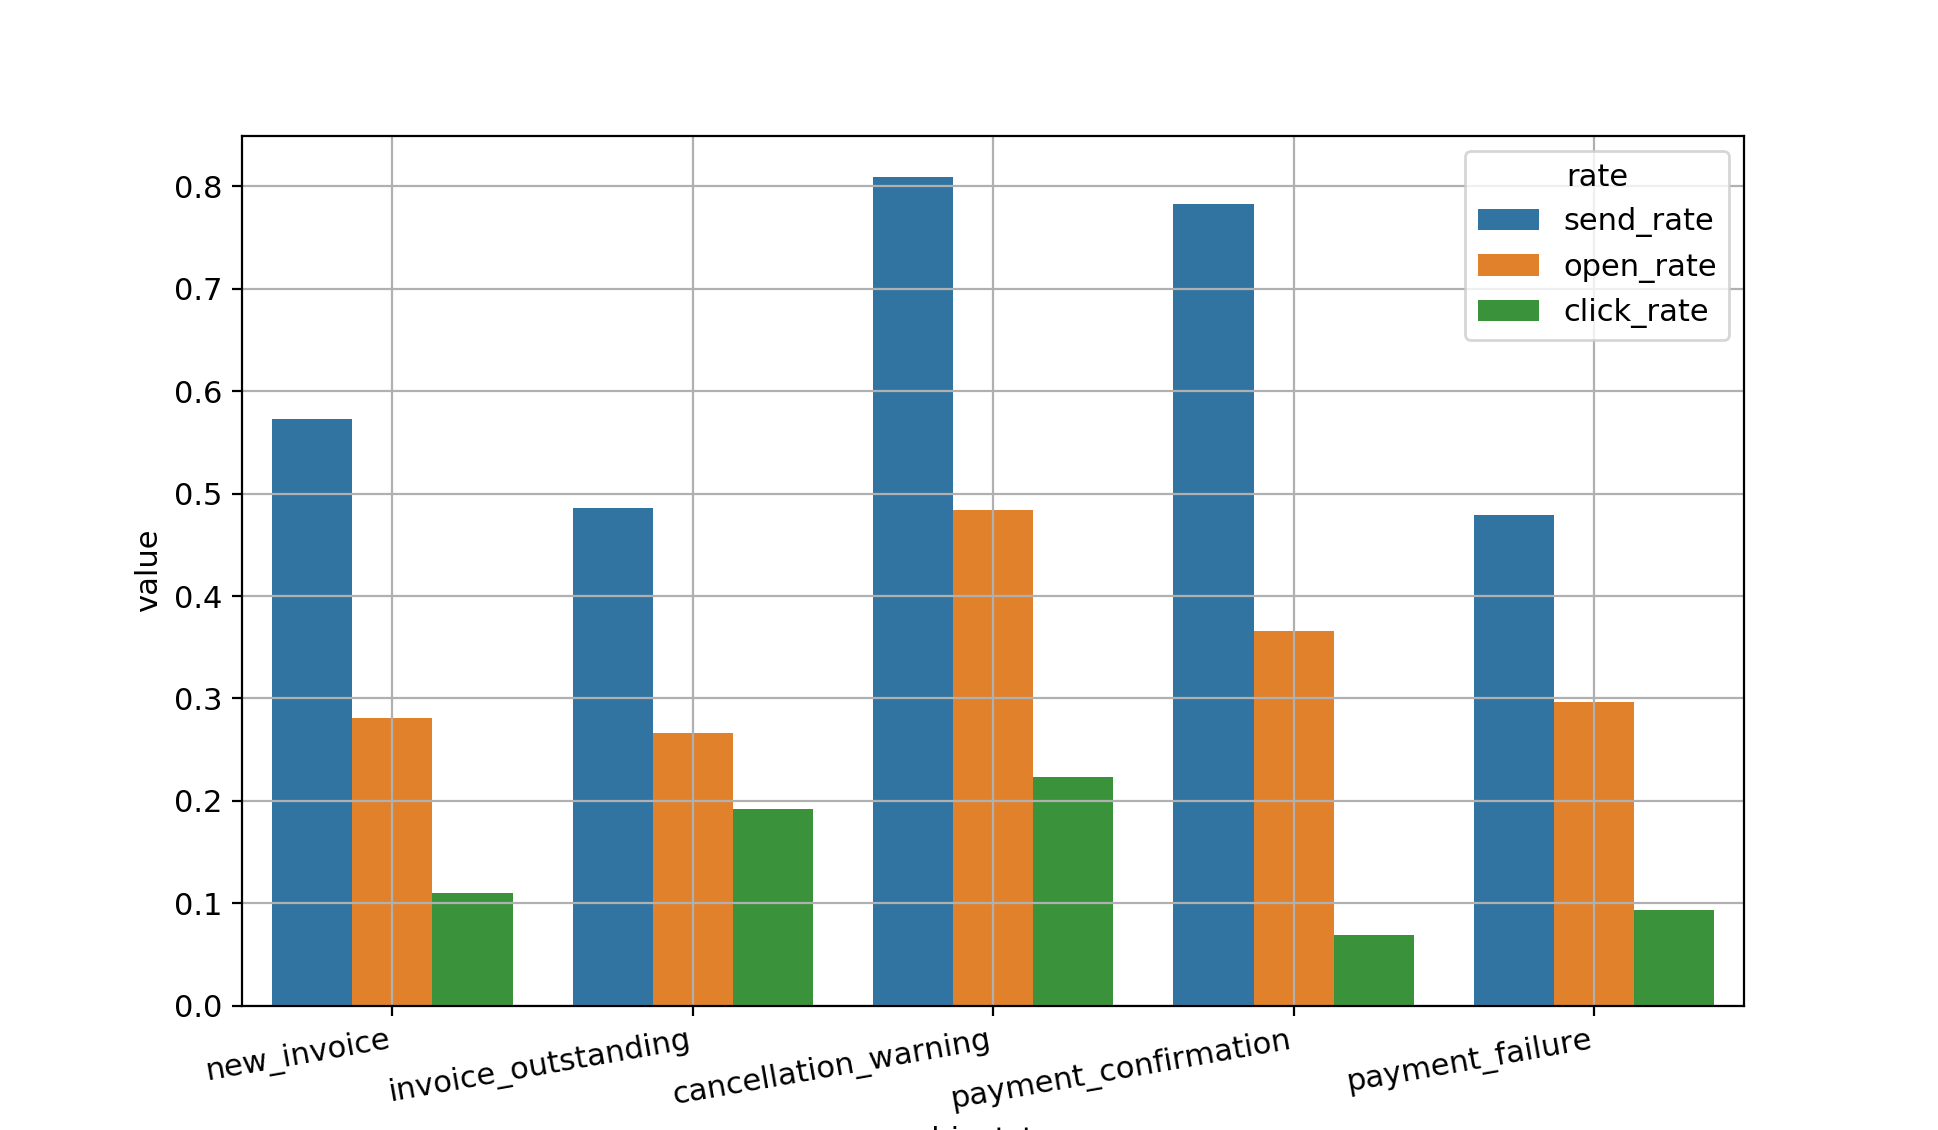

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

In [785]:
fig, ax = plt.subplots()

sns.barplot(x='subject_type',
            y='value',
            hue='rate',
            data=np_mean_rates_funnel.sort_values('subject_type').melt(
                id_vars='subject_type', value_name='value', var_name='rate'),
            ax=ax)

ax.grid()
plt.xticks(rotation=10, ha='right')

### Payment Plan & Method

In [366]:
df_np = df_np.astype({'account_number':str})

In [412]:
np_pay = df_np.merge(df_pay, on='account_number', how='left').copy()

In [436]:
np_pay['account_number'].nunique()

712

Payment method, ~2 methods per account, not many checks

In [435]:
np_pay.groupby('account_number')['payment_method'].nunique().describe()

count    712.000000
mean       2.018258
std        0.607921
min        1.000000
25%        2.000000
50%        2.000000
75%        2.000000
max        4.000000
Name: payment_method, dtype: float64

In [441]:
np_pay.head()

account_number              account_name              producer_email  \
0     0003255436  surfaces & coverings inc        chaimp@athruzins.com   
1     0007732193           GICK FAMILY LLC     misty.steele@appund.com   
2     0022355875    El Conuco Acevedo Corp  alexandriainc1@verizon.net   
3     0022355875    El Conuco Acevedo Corp  alexandriainc1@verizon.net   
4     0022355875    El Conuco Acevedo Corp  alexandriainc1@verizon.net   

  cancel_date            payment_method                     payment_plan_name  \
0  2020-02-24  Unapplied fund (Account)                             Quarterly   
1  2020-03-21  Unapplied fund (Account)  Monthly 20% Down, 9 Max installments   
2  2020-02-12                   ACH/EFT                             Quarterly   
3  2020-02-12               Credit Card                             Quarterly   
4  2020-02-12  Unapplied fund (Account)                             Quarterly   

  stripe_auto_pay  
0           False  
1           False  
2            True  
3            True  
4            True

In [437]:
np_pay.groupby('payment_method')['account_number'].nunique().sort_values(ascending=False)

payment_method
Unapplied fund (Account)    712
ACH/EFT                     374
Credit Card                 329
Check                        22
Name: account_number, dtype: int64

payment_method  
ACH/EFT, 256222  
Unapplied fund (Account), 177526  
Credit Card, 153362  
Check, 4658  
Cash, 390  
Wire, 156

Payment Plan not remarkable

In [438]:
np_pay.groupby('account_number')['payment_plan_name'].nunique().describe()

count    712.000000
mean       1.011236
std        0.105477
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        2.000000
Name: payment_plan_name, dtype: float64

In [377]:
np_pay.groupby('payment_plan_name')['account_number'].nunique().sort_values(ascending=False)

payment_plan_name
Monthly 20% Down, 9 Max installments    412
Quarterly                               142
Full Pay                                 98
Name: account_number, dtype: int64

payment_plan_name  
"Monthly 20% Down, 9 Max installments", 423016  
Full Pay, 97787  
Quarterly, 71165  
Semi-Annual, 346  


Auto Pay is Opposite Typical Trend

In [374]:
np_pay.groupby('stripe_auto_pay')['account_number'].nunique()

stripe_auto_pay
False    448
True     196
Name: account_number, dtype: int64

stripe_auto_pay  
False, 215975  
True, 376339  